# Cape Town Air BNB Prices #

## 1. Import Libraries and Read in Data

In [31]:
import pandas as pd
pd.set_option('display.max_columns', 300)

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')   
import scipy.stats as stats
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
from geopy.distance import great_circle



In [17]:
# Read in data 
listing_df = pd.read_csv('listings.csv')

In [18]:
listing_df.shape

(24079, 16)

## 2. Clean the data. 

In [19]:
# Dealing with NAs 
listing_df.isna().sum()

id                                    0
name                                  0
host_id                               0
host_name                             3
neighbourhood_group               24079
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                        6823
reviews_per_month                  6823
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [20]:
# Because the data set is over 24k, I decided to drop the nan values of reviews and last review (the same rows were nan for each)
# In researching SA Cape Town Air BNB, I found that houses with no reviews tended to have been expensive, but never booked

listing_df.dropna(subset = ['reviews_per_month', 'last_review'], axis = 0, inplace = True)

In [21]:
# Closed listing does not exist 9775 is 20685098 and it is listed as price = 0 

listing_df[listing_df.price == 0.0]
listing_df.drop(9775, inplace = True)

In [22]:
# Seemingly half of the rates were in ZAR and half in dollars (lower cost was in USD)
# Air BNB zar conversion rate is 14.3 (current rate is 16.5)
# The most expensive house I could find was 3,000 that had been reviewed once/had been booked

listing_df['price_usd'] = listing_df.price.apply(lambda x: x/14.23 if x>= 3000 else x)

In [23]:
#listing append 9808 is 20736711 price was 0.0 is actually 121 USD, minimum night 7

listing_df.at[9808, 'price_usd'] = 121
listing_df.at[9808, 'minimum_nights'] = 7

In [24]:
# Splitting by room type by making dummy binomial variables

listing_df = pd.get_dummies(listing_df, columns=['room_type'])

In [25]:
# Neighbourhoods

listing_df.neighbourhood = listing_df.neighbourhood.map(lambda x: x.replace('Ward', ''))

In [26]:
listing_df.neighbourhood = listing_df.neighbourhood.astype(int)

## 3. Feature Engineering 

In [27]:
# testing features

listing_df['price_usd_log'] = np.log(listing_df['price_usd'])

In [28]:
# Feature Engineering

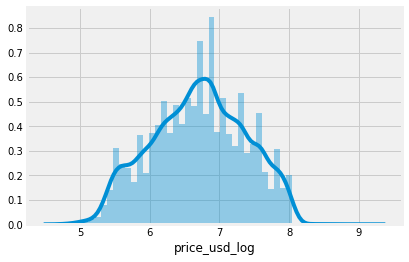

In [29]:
# Using the log I can normalize the plot a little bit 
sns.distplot(listing_df['price_usd_log'])

In [32]:
# Distance to Cape Town City Center

city_center = (-33.9249,18.4241)
listing_df['distance_cc'] = listing_df[['latitude', 'longitude']].apply(lambda x: great_circle(city_center, 
                                                                                               (x['latitude'], x['longitude'])).miles, axis = 1)
# Distance VA Waterfront 

va_water = (-33.9036, 18.4205)
listing_df['distance_waterfront'] = listing_df[['latitude', 'longitude']].apply(lambda x: great_circle(va_water, 
                                                                                               (x['latitude'], x['longitude'])).miles, axis = 1)

# Stellenbosch 

wine_lands = (-34.075691, 18.843266)
listing_df['distance_wine'] = listing_df[['latitude', 'longitude']].apply(lambda x: great_circle(wine_lands, 
                                                                                               (x['latitude'], x['longitude'])).miles, axis = 1)

# Distance from Airport

airport = (-33.9249,18.4241)
listing_df['distance_airport'] = listing_df[['latitude', 'longitude']].apply(lambda x: great_circle(airport, 
                                                                                               (x['latitude'], x['longitude'])).miles, axis = 1)


## 4. Statistical Testing

In [33]:
#Statistical Testing

In [34]:
# minimum nights > 4
# min nights < 4 
# mean min_nights is 3.93
# Prices of Air BNBs with less than 4 minimum nights is statistically different than houses with minimum nights greater or equal to 4. 


x = listing_df[listing_df['minimum_nights'] >= 4]['price_usd_log']
y = listing_df[listing_df['minimum_nights'] < 4]['price_usd_log']
stats.f_oneway(x, y)

F_onewayResult(statistic=10.301412241737964, pvalue=0.001331716064438783)

In [35]:
# As we get closer the the City Center, the mean of the price changes. 


x = listing_df[listing_df['distance_cc'] >= 10]['price_usd_log']
y = listing_df[listing_df['distance_cc'] < 10]['price_usd_log']
ten_miles = stats.f_oneway(x, y)

x = listing_df[listing_df['distance_cc'] >= 8]['price_usd_log']
y = listing_df[listing_df['distance_cc'] < 8]['price_usd_log']
eight_miles = stats.f_oneway(x, y)

x = listing_df[listing_df['distance_cc'] >= 1]['price_usd_log']
y = listing_df[listing_df['distance_cc'] < 1]['price_usd_log']
one_mile = stats.f_oneway(x, y)

print('10 miles: ', ten_miles)
print('8 miles: ', eight_miles)
print('1 mile: ', one_mile)

10 miles:  F_onewayResult(statistic=3.5676551475236833, pvalue=0.05893220680422791)
8 miles:  F_onewayResult(statistic=10.562734536727625, pvalue=0.0011561144208251598)
1 mile:  F_onewayResult(statistic=91.55364227586814, pvalue=1.2290429745611808e-21)


In [36]:
# Independent T Test we can also see that the distance_cc is statistically different when looked over a mile to city center

ttest_distance_cc = stats.ttest_ind(listing_df[listing_df['distance_cc'] < 1]['price'], listing_df[listing_df['distance_cc'] >=1]['price_usd']) 
ttest_distance_cc

Ttest_indResult(statistic=19.543926221594283, pvalue=3.7730804501344767e-84)

## 5. Baseline model

In [37]:
# Baseline model; rmse:  669.5434143725225 r2:  0.0 using mean

subset = ['neighbourhood', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']
x = listing_df[subset]
y = listing_df['price_usd']

dummy_regr = DummyRegressor(strategy = "mean")
dummy_regr.fit(x, y)
#DummyRegressor()
y_predict = dummy_regr.predict(y)
R2 = dummy_regr.score(x, y)

rmse = np.sqrt(metrics.mean_squared_error(y, y_predict))

print('rmse: ', rmse, 'r2: ', R2)

rmse:  669.5434143725225 r2:  0.0


In [38]:
# Baseline model; rmse:  693.2896480095063 r2:  -0.07219047711717841 using median

subset = ['neighbourhood', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']
x = listing_df[subset]
y = listing_df['price_usd']

dummy_regr = DummyRegressor(strategy = "median")
dummy_regr.fit(x, y)
#DummyRegressor()
y_predict = dummy_regr.predict(y)
R2 = dummy_regr.score(x, y)

rmse = np.sqrt(metrics.mean_squared_error(y, y_predict))

print('rmse: ', rmse, 'r2: ', R2)

rmse:  693.2896480095063 r2:  -0.07219047711717841


## 6. Test for Multi-Colinearity  

## 7. Model Testing